In [67]:
# Частота дискретизации
fs = 44100
# Целевая частота
fb = 2730
# Количество отсчётов в выборке
n_samples = 1024

In [68]:
# Длительность выборки
t_chunk = 1.0 / fs * n_samples
print('Длительность выборки: ms', t_chunk * 1000)

Длительность выборки: ms 23.219954648526077


In [69]:
print("Количество периодов целевого сигнала в выборке:", t_chunk / (1.0 / fb))

Количество периодов целевого сигнала в выборке: 63.39047619047619


## Загрузка сигнала

In [6]:
from os.path import dirname, join as pjoin
from scipy.io import wavfile
import scipy.io
import os

In [8]:
data_dir = pjoin(os.getcwd(), 'data')
wav_file_name = pjoin(data_dir, 'mixed-signal.wav')

samplerate, data = wavfile.read(wav_file_name)
print(f"number of channels = {data.shape[1]}")
length = data.shape[0] / samplerate
print(f"length = {length}s")

number of channels = 2
length = 0.37151927437641724s


In [9]:
import matplotlib.pyplot as plt
import numpy as np

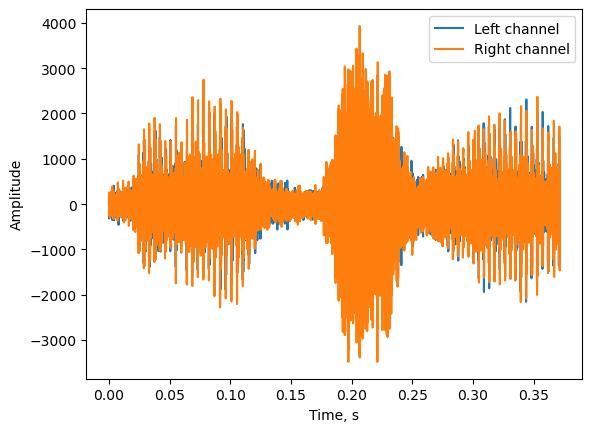

In [10]:
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data[:, 0], label="Left channel")
plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.show()

In [11]:
number_of_chunks = min(16, data.shape[0]//1024)
print(f"Number of chunks to analyse {number_of_chunks}")

Number of chunks to analyse 16


## Зашумлённый сигнал

In [3]:
from scipy.fftpack import fft

In [30]:
frequency_x = np.linspace(0., fs / 2., n_samples // 2)

In [31]:
clc_fft = np.abs(fft(data[:n_samples,1], n_samples))
clc_fft = 20*np.log10(10e-11+clc_fft/np.max(clc_fft))

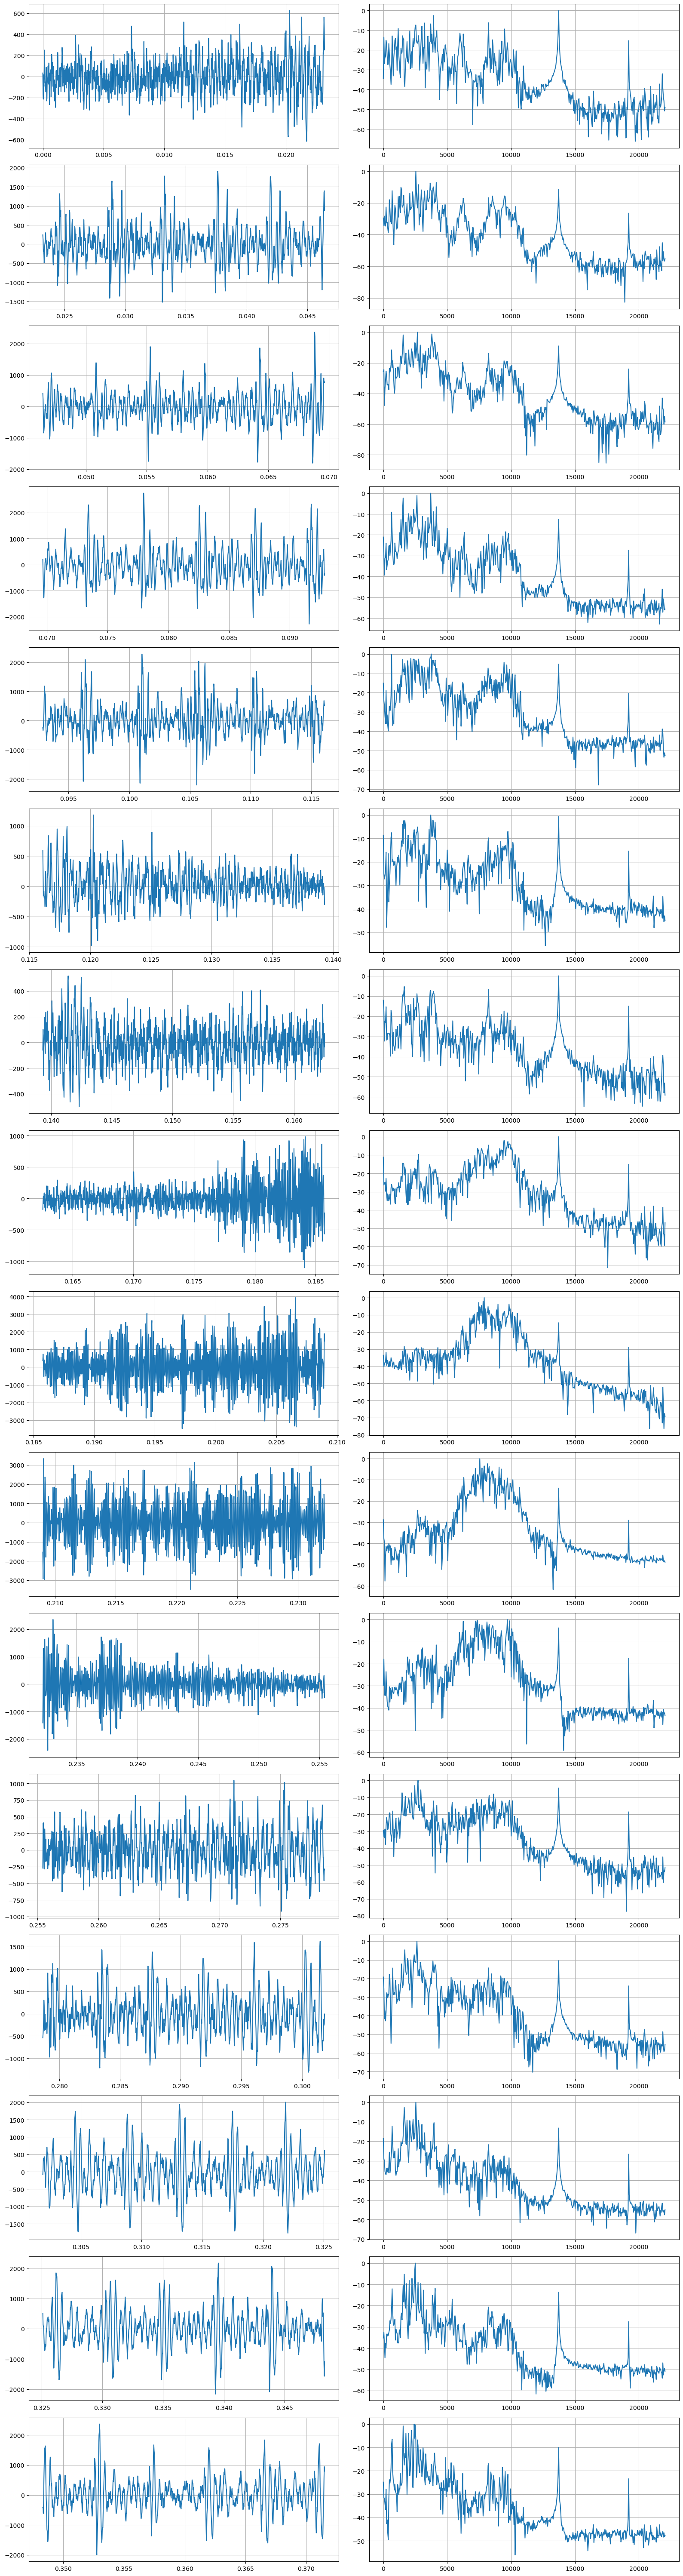

In [35]:
plt.figure(figsize=(16,60))
for i in range(number_of_chunks):
    start = i * n_samples
    # draw raw signal
    plt.subplot(number_of_chunks, 2, i*2 + 1)
    plt.plot(time[start:start+1024], data[start:start+1024, 1])
    plt.grid(True)
    # draw its spectrum
    clc_fft = np.abs(fft(data[start:start+n_samples,1], n_samples))
    clc_fft = 20*np.log10(10e-11+clc_fft/np.max(clc_fft))
    plt.subplot(number_of_chunks, 2, i*2+2)
    plt.plot(frequency_x, clc_fft[:n_samples // 2])
    plt.grid(True)
plt.tight_layout()

## Рассчет полосового фильтра

In [70]:
import numpy as np
from scipy.signal import firwin2, lfilter

In [71]:
lst_freqs = np.linspace(0, fs/2, 100)
lst_freqs

array([    0.        ,   222.72727273,   445.45454545,   668.18181818,
         890.90909091,  1113.63636364,  1336.36363636,  1559.09090909,
        1781.81818182,  2004.54545455,  2227.27272727,  2450.        ,
        2672.72727273,  2895.45454545,  3118.18181818,  3340.90909091,
        3563.63636364,  3786.36363636,  4009.09090909,  4231.81818182,
        4454.54545455,  4677.27272727,  4900.        ,  5122.72727273,
        5345.45454545,  5568.18181818,  5790.90909091,  6013.63636364,
        6236.36363636,  6459.09090909,  6681.81818182,  6904.54545455,
        7127.27272727,  7350.        ,  7572.72727273,  7795.45454545,
        8018.18181818,  8240.90909091,  8463.63636364,  8686.36363636,
        8909.09090909,  9131.81818182,  9354.54545455,  9577.27272727,
        9800.        , 10022.72727273, 10245.45454545, 10468.18181818,
       10690.90909091, 10913.63636364, 11136.36363636, 11359.09090909,
       11581.81818182, 11804.54545455, 12027.27272727, 12250.        ,
      

In [72]:
target_freqs = np.logical_not(np.logical_or(lst_freqs < fb-fs/2/100, lst_freqs > fb+fs/2/100))

In [73]:
target_freqs

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [74]:
lst_gain = np.select([np.logical_not(target_freqs), target_freqs], [np.zeros(len(target_freqs)), np.ones(len(target_freqs))])

In [75]:
NFIR = 64
taps = firwin2(NFIR, lst_freqs, lst_gain, fs=fs)

In [76]:
taps

array([ 0.00124738,  0.00113083,  0.00087081,  0.00042873, -0.00022438,
       -0.00107229, -0.0020257 , -0.00291438, -0.00350703, -0.00355836,
       -0.00287472, -0.00138237,  0.00082072,  0.00344705,  0.00604653,
        0.00807878,  0.00901986,  0.00848215,  0.00632074,  0.00269959,
       -0.00190243, -0.00675335, -0.01099056, -0.01378257, -0.01449799,
       -0.01284603, -0.0089569 , -0.00338157,  0.00299285,  0.00909834,
        0.01388236,  0.01650637,  0.01650637,  0.01388236,  0.00909834,
        0.00299285, -0.00338157, -0.0089569 , -0.01284603, -0.01449799,
       -0.01378257, -0.01099056, -0.00675335, -0.00190243,  0.00269959,
        0.00632074,  0.00848215,  0.00901986,  0.00807878,  0.00604653,
        0.00344705,  0.00082072, -0.00138237, -0.00287472, -0.00355836,
       -0.00350703, -0.00291438, -0.0020257 , -0.00107229, -0.00022438,
        0.00042873,  0.00087081,  0.00113083,  0.00124738])

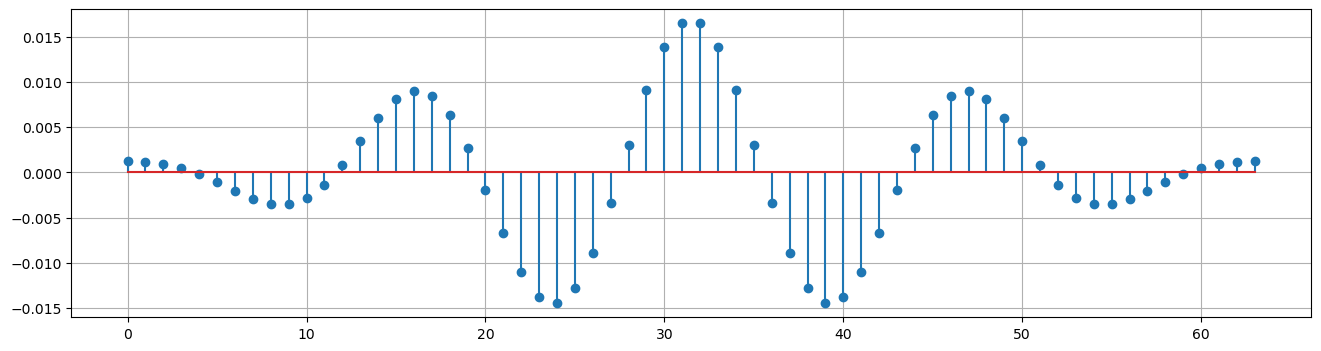

In [77]:
plt.figure(figsize=(16,4), dpi=100)
plt.stem(taps)
plt.grid()

## Отфильтрованный сигнал

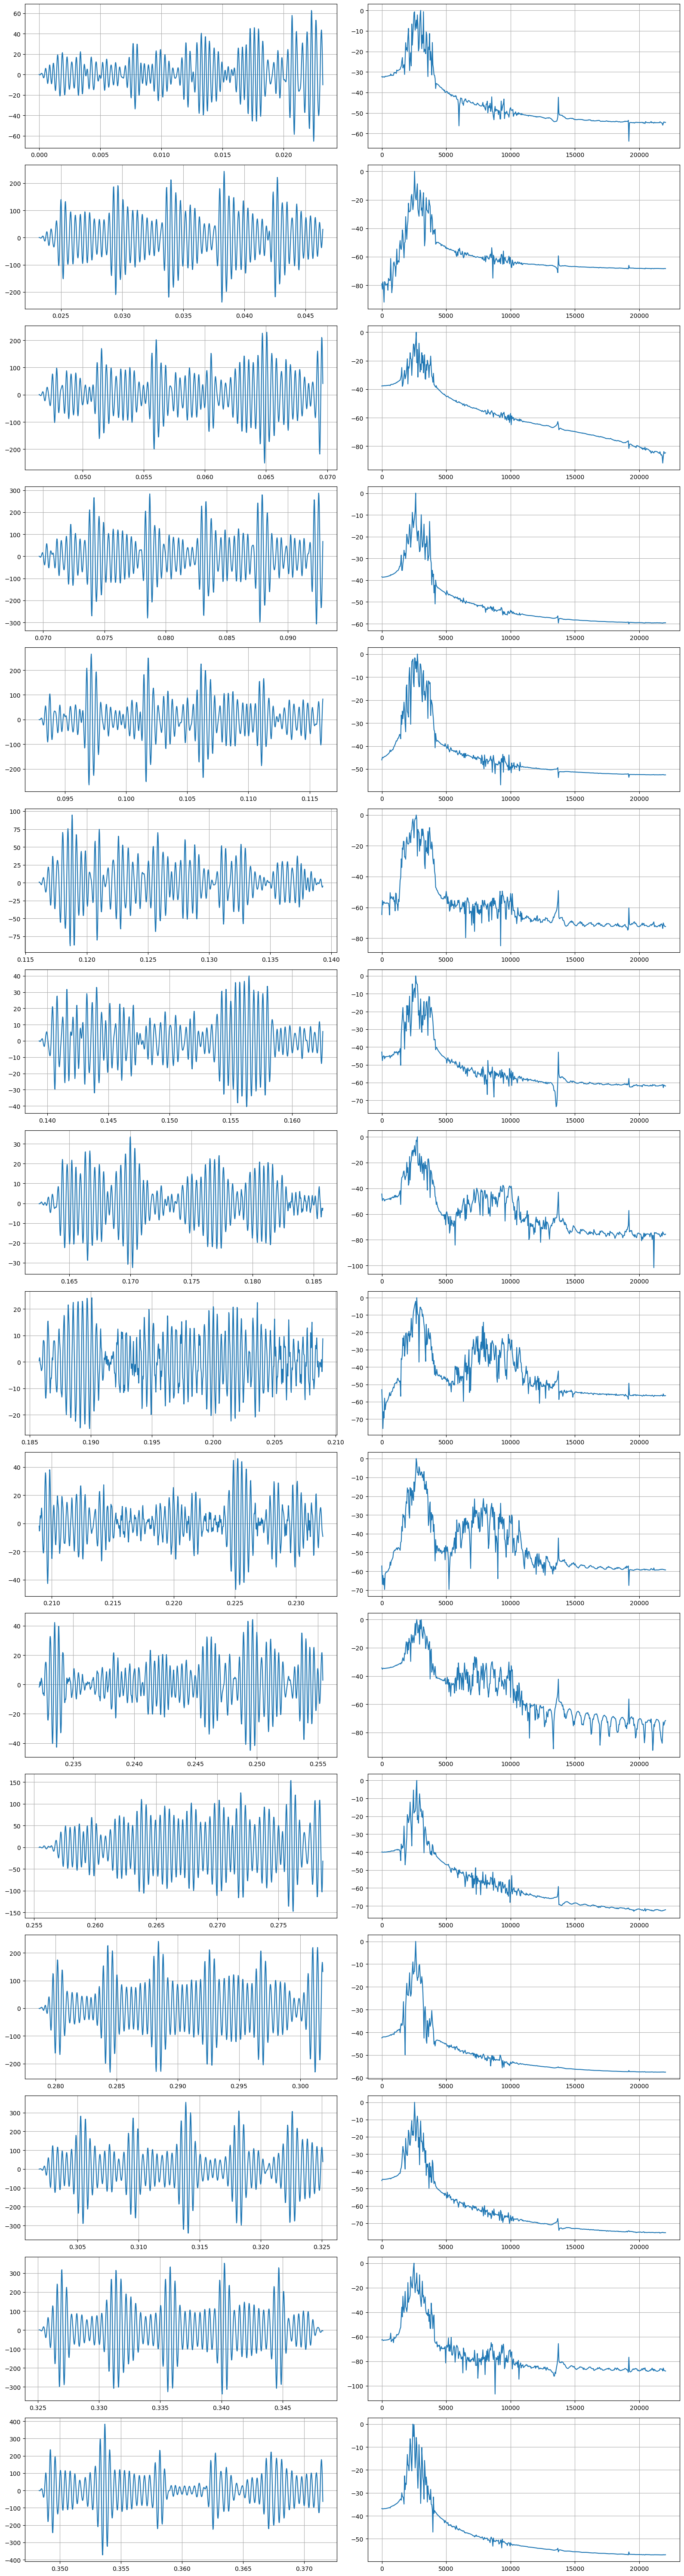

In [78]:
plt.figure(figsize=(16,60))
for i in range(number_of_chunks):
    start = i * n_samples
    # draw raw signal
    plt.subplot(number_of_chunks, 2, i*2 + 1)
    y = lfilter(taps, 1, data[start:start+1024, 1])
    plt.plot(time[start:start+1024], y)
    plt.grid(True)
    # draw its spectrum
    clc_fft = np.abs(fft(y, n_samples))
    clc_fft = 20*np.log10(10e-11+clc_fft/np.max(clc_fft))
    plt.subplot(number_of_chunks, 2, i*2+2)
    plt.plot(frequency_x, clc_fft[:n_samples // 2])
    plt.grid(True)
plt.tight_layout()

## Выгрузка сигнала

In [66]:
full_y = lfilter(taps, 1, data[:, 1])
out_wav_file_name = pjoin(data_dir, 'mixed-signal-out.wav')
wavfile.write(out_wav_file_name, fs, full_y.astype(np.int16))